In [1]:
"""
https://www.analyticsvidhya.com/blog/2020/05/tutorial-real-time-lane-detection-opencv/
여기 사이트 내용을 참고했음.
"""

'\nhttps://www.analyticsvidhya.com/blog/2020/05/tutorial-real-time-lane-detection-opencv/\n여기 사이트 내용을 참고했음.\n'

In [2]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [3]:
"""
각종 경로 설정하기
"""
# 이미지 파일로 저장된, 도로 사진 : 입력
dir_path_img_frames_read = 'resource/set1/frames_in/'

# 여기 구현된 알고리즘으로 차선 탐지가 된 도로 사진을 저장할 폴더 : 출력
dir_path_img_frames_write = 'resource/set1/frames1_out-v1/'

# 차선 탐지가 된 도로 사진을 동영상으로 만들어서 저장할 결과물
dir_path_video_out = 'resource/set1/'
video_out_filename = 'set1-output-v1.mp4'

# github에 업로드 할 이미지를 저장해 두기 위한 폴더
dir_important_imgs = 'v1-out-imgs'

print('done')

done


In [4]:
"""
주요 파라미터 설정하기
"""
target_height = 270  # 영상의 폭
target_width = 480  # 영상의 높이

In [5]:
"""
Read Video Frames
비디오 : https://www.youtube.com/watch?reload=9&v=KWJaBJYJIjI
Frames : 비디오 촬영 영상을 연속된 이미지로 변경 해 놓은 것 (사진파일 다수)

비디오를 직접 입력으로 받지 않고, 비디오를 사진으로 변환한 다음에
사진 파일을 입력으로 받아서 처리한다.
"""

col_frames = os.listdir(dir_path_img_frames_read)
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread(dir_path_img_frames_read + i)
    # 이미지를 고정된 크기로 변경
    # 입력으로 들어오는 이미지가, 내가 원하는 크기가 아니면, 내가 원하는 크기로 변경
    height, width = img.shape[:2]
    if (height != target_height) or (width != target_width):
        img = img.resize(img, dsize=(target_width, target_height))
        
    col_images.append(img)        

# 읽어온 사진 파일 검증
num_images = len(col_images)
height, width = col_images[0].shape[:2]
print('num images read : ', num_images)
print('image shape : ', height, width)
print('done')

C:\Users\cjh43\anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



num images read :  1108
image shape :  270 480
done


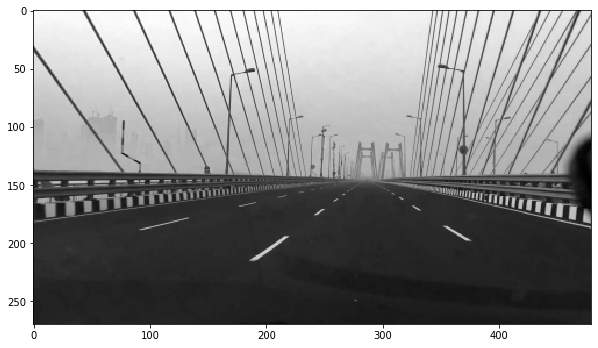

done


In [6]:
# 읽어온 사진 중에서 랜덤으로 하나 골라서 화면에 출력하기

import random
%matplotlib inline

# specify frame index
#idx = random.randint(0, num_images)  # 랜덤으로 이미지 하나 고르기
idx = 1  # 1번 이미지를 선택 : Hough Line Tranf 했을때, 차선 일부만 탐지됨
         # v2, v3 에서 이러한 문제를 개선할 것이므로, 1번 이미지를 예시로 선택

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

print('done')

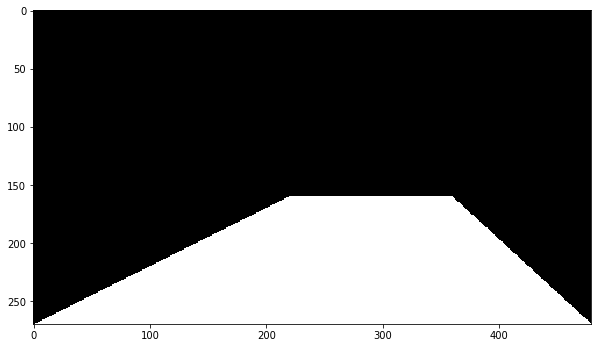

done


In [7]:
"""
Frame Mask Creation : 관심없는 부분은 검은색으로 덮어버리는 부분
즉, 바로 앞에 있는 차선 부분을 제외하고는 모두 검은색으로 덮어서,
차선 탐지가 더 잘 되도록...
=> 차량에 달린 카메라를 통해서 들어오는 영상에 따라서 mask를 약간 조절할 필요가 있을듯.

Our region of interest is in the shape of a polygon. 
We want to mask everything except this region. 
Therefore, we first have to specify the coordinates of the polygon 
and then use it to prepare the frame mask:
"""

# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
#
# 촬영한 영상에 따라서 다각형의 형태를 조절할 필요가 있겠다.
#
polygon = np.array([[0,270], [220,160], [360,160], [480,270]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

# 결과를 화면에 표시 : 아무것도 없는 화면에 다각형의 흰색 + 나머지 검은색 생성
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

print('done')

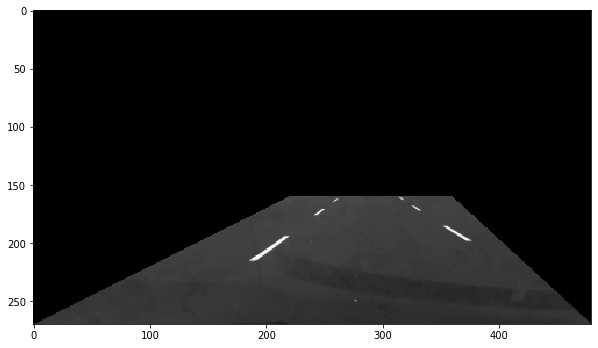

done


In [8]:
# 이렇게 생성한 다각형을, 실제 도로 사진 위에 덮기
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

print('done')

In [9]:
"""
다음 작업은 Image pre-processing (이미지 전처리 과정)
원하는 차선을 감지하기 위해서 이미지 전처리 과정을 두 번 거쳐야 함

전처리 과정은 다음과 같다:
1) Image Thresholding
2) Hough Line Transformation
"""

'\n다음 작업은 Image pre-processing (이미지 전처리 과정)\n원하는 차선을 감지하기 위해서 이미지 전처리 과정을 두 번 거쳐야 함\n\n전처리 과정은 다음과 같다:\n1) Image Thresholding\n2) Hough Line Transformation\n'

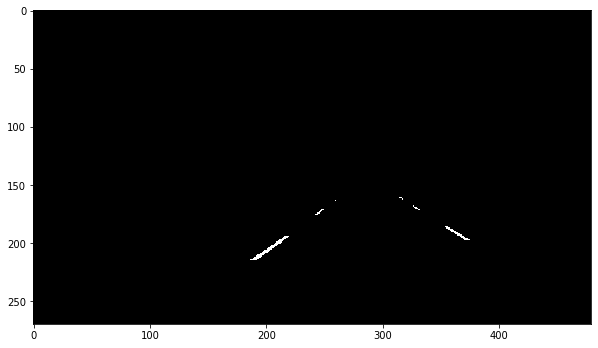

done


In [10]:
"""
1. Image Thresholding
카메라로 획득한 사진을 gray-scale로 변환한 다음에 threshold 기반의 변환 기법을 사용함
즉, [이미지 픽셀값 >= threshold] 이면 한가지 색으로 변환하고
나머지 경우에는 다른 색으로 변환해서, 
이미지를 단순화 하고, 차선 탐지를 쉽게 만들기

-- 메소드 설명 --
cv2.threshold(img, threshold_value, value, flag)

img: Grayscale 이미지
threshold_value: 픽셀 문턱값
value: 픽셀 문턱값보다 클 때 적용되는 최대값
flag: 문턱 값 적용 방법 또는 스타일 결정
    cv2.THRESH_BINARY: 픽셀 값이 threshold_value보다 크면 value, 작으면 0으로 할당
    cv2.THRESH_BINARY_INV: 픽셀 값이 threshold_value보다 크면 0, 작으면 value로 할당
    cv2.THRESH_TRUNC: 픽셀 값이 threshold_value보다 크면 threshold_value, 작으면 픽셀 값 그대로 할당
    cv2.THRESH_TOERO: 픽셀 값이 threshold_value보다 크면 픽셀 값 그대로, 작으면 0으로 할당
    cv2.THRESH_TOZERO_INV: 픽셀 값이 threshold_value보다 크면 0, 작으면 픽셀 값 그대로 할당
"""

# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

print('done')

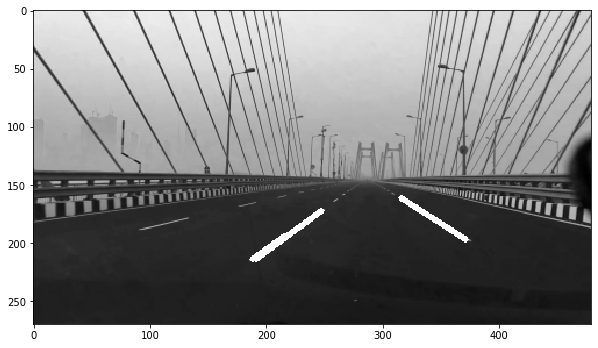

done


In [11]:
"""
2. Hough Line Transformation
차선 탐지
"""

# https://m.blog.naver.com/windowsub0406/220894462409
# 흑백으로 변환된 이미지만 입력으로 받을 수 있음
'''
허프변환(cv2.HoughLines)은 모든 점에 대해서 계산을 하기 떄문에 시간이 많이 소요됨. 확률 허프 변환은 허프 변환을 최적화한 것이다.
모든 점을 대상으로 하는 것이 아니라 임의의 점을 이용하여 직선을 찾는 것.

cv2.HoughLinesP(image, rho, theta, threshold, minLineLength, maxLineGap)
    image: 8bit, single-channel binary image, canny edge를 선으로 적용함.
    rho: r 값의 범위(0 ~ 1 사이 실수).
    theta: 𝜃 값의 범위(0 ~ 180 정수).
    threshold: 만나는 점의 기준, 숫자가 작으면 많은 선이 검출되지만 정확도가 떨어지고, 숫자가 크면 정확도가 올라감
    minLineLength: 선의 최소 길이. 이 값보다 작으면 reject됨.
    maxLineGap: 선과 선 사이의 최대 허용 간격, 이 값보다 작으면 reject됨.

'''
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
    '''
    Hough Line 알고리즘으로 선을 탐지한경우, 탐지한 선의 한쪽 끝 (x1,y1) 과 다른쪽 끝 (x2,y2) 을 알 수 있음.
    '''
    x1, y1, x2, y2 = line[0]
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)  # 사진 복사본 위에, 탐지한 선을 그려넣기

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.savefig(dir_important_imgs + '/detection-result.png', dpi=300)
plt.show()

print('done')

C:\Users\cjh43\anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Type Error가 발생했습니다.
Error at INDEX :  968


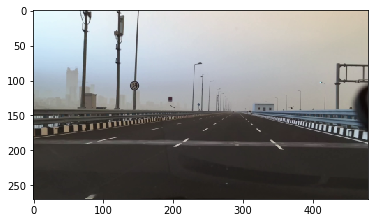

Type Error가 발생했습니다.
Error at INDEX :  1089


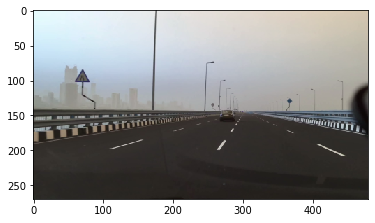

Type Error가 발생했습니다.
Error at INDEX :  1090


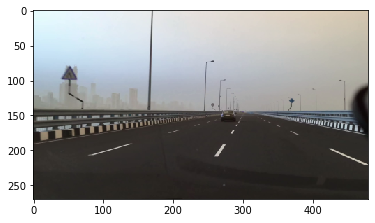

Type Error가 발생했습니다.
Error at INDEX :  1095


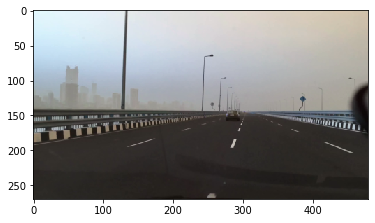

Type Error가 발생했습니다.
Error at INDEX :  1096


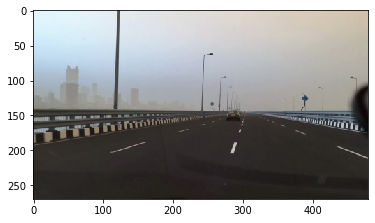


done, processed image count :  1108


In [12]:
"""
위의 2개 과정 (threshold => hough transf) 을 모든 사진 프레임에 적용
"""
cnt = 0

for img in tqdm_notebook(col_images):
    # frame mask 적용하기
    masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  
    # image thresholding 적용하기
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)

    # Hough Line Transformation 적용하기
    # HoughLinesP : Probabilistic Hough Transform
    # https://opencv-python.readthedocs.io/en/latest/doc/
    #         25.imageHoughLineTransform/imageHoughLineTransform.html
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
    dmy = img.copy()  # 원본 이미지 복사본 만들어서, 그 위에다가 탐지한 선을 그리기
  
    # Plot detected lines
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',dmy)  # 수정본 그림 저장
    except TypeError: 
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',img)  # 원본 그림 저장
        """
        오류가 언제, 왜 발생하는지 분석이 안되서, 일단은 그냥 무시하는 것으로...
        """
        print('Type Error가 발생했습니다.')
        print('Error at INDEX : ', cnt)
        plt.imshow(dmy)
        plt.show()        
        #assert False, "Type Error 가 발생했습니다."

    cnt+= 1

print('done, processed image count : ', cnt)

In [13]:
"""
차선 탐지된 이미지를 묶어서 비디오로 만들기 (1/3)
"""

# specify frames per second
fps = 30.0

from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(dir_path_img_frames_write) 
         if isfile(join(dir_path_img_frames_write, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

print('done')

done


In [14]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (2/3)
# Next, we will get all the frames with the detected lane into a list:

frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename = dir_path_img_frames_write + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)
    
print('done')    

C:\Users\cjh43\anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



done


In [15]:
# 차선 탐지된 이미지를 묶어서 비디오로 만들기 (3/3)
# Finally, we can now combine the frames into a video by using the code below:

# write the video
path_out = dir_path_video_out + video_out_filename
'''
영상을 저장하기 위해서 videowriter를 사용해야 한다.
cv2.VideoWriter(outputFile, fourcc, frame, size)
    outputFile(str): 저장될 파일 이름
    fourcc: Codec 정보. cv2.VideoWriter_fourcc()
        frame(float): 초당 저장될 frame
        size(list): 저장될 사이즈(ex; 640 * 480)
'''
out = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()

print('done')

done
